# Notebook to format data from "Extreme Diel Variation in the feeding behavior of humpback whales along the western Antarctic Peninsula during autumn", Friedlaender et al (2013).

Paper can be found [here](https://www.researchgate.net/publication/260209964_Extreme_diel_variation_in_the_feeding_behavior_of_humpback_whales_along_the_western_Antarctic_Peninsula_during_autumn).

Data was supplied by Ari Friedlaender directly, he agreed to have it posted publicly

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import scipy.io as sio

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/friedlaender_whales'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/friedlaender_whales'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
# features_fps = glob.glob(raw_data_dir + '/*.h5')
annotations_fps = glob.glob(raw_data_dir + '/annotations/*.csv')

# Currently missing this processed data file:
annotations_fps.remove('/home/jupyter/behavior_data_local/data/raw/friedlaender_whales/annotations/DiveInfo-mn09_122b.csv')

clip_ids = sorted([x.split('/')[-1].split('.')[0].split('-')[-1] for x in annotations_fps])
data_fps = [raw_data_dir + '/' + clip_id + '/' +clip_id +'prh_speed.mat' for clip_id in clip_ids]

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
for fp in data_fps:
    if not os.path.exists(fp):
        print(fp)
        
print('checked all data files exist!')

checked all data files exist!


In [6]:
# Dataset metadata
dataset_metadata = {}
sr = 5
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'friedlaender_whales'

In [7]:
## Integer codes for individuals

individual_ids = []
clip_id_to_individual_id = {}
for i, clip_id in enumerate(clip_ids):
    clip_id_to_individual_id[clip_id] = i
    individual_ids.append(i)

dataset_metadata['individual_ids'] = individual_ids
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

In [8]:
clip_id_to_individual_id

{'mn09_127a': 0,
 'mn09_148a': 1,
 'mn09_152a': 2,
 'mn10_132a': 3,
 'mn10_133a': 4,
 'mn10_139a': 5,
 'mn10_144a': 6,
 'mn10_151a': 7}

In [9]:
# Set up data splits by individual

test_proportion = .25
val_proportion = .2
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(61) #60
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individuals.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

[0, 1, 3, 4, 6]
[5]
[0, 1, 3, 4, 5, 6]
[2, 7]


In [10]:
# Set up clip ids 

# Clip ids
test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
dev_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

In [11]:
## Integer codes for specific behaviors

# list of behaviors (from metadata sent by Ari)
beh_names = ['unknown', 
             'rest', 
             'travel', 
             'exploratory', 
             'feed']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

# extract directly from the annotations
fp = annotations_fps[0]
individual_annotations = pd.read_csv(fp)
clip_id = fp.split('/')[-1].split('.')[0].split('-')[-1]
individual_annotations['clip_id'] = clip_id
individual_annotations['individual'] = clip_id_to_individual_id[clip_id]
all_annotations = individual_annotations

for fp in annotations_fps[1:]:
    individual_annotations = pd.read_csv(fp)
    clip_id = fp.split('/')[-1].split('.')[0].split('-')[-1]
    individual_annotations['clip_id'] = clip_id
    individual_annotations['individual'] = clip_id_to_individual_id[clip_id]
    all_annotations = all_annotations.append(individual_annotations)
    
all_annotations.reset_index(inplace = True)

all_annotations

,index,start_cue,end_cue,max_depth,cue_at_max_depth,mean_depth,mean_compression,dive_ID,Tdown,Tup,numLun,behav_state,clip_id,individual
0,0,106.0,181.0,15.359074,141.0,9.802582,0.540365,1,75.0,392.6,0,2,mn09_127a,0
1,1,573.6,723.2,11.587490,656.6,6.564626,0.625480,2,149.6,123.2,0,2,mn09_127a,0
2,2,846.4,901.4,6.402085,877.4,4.133412,0.720284,3,55.0,116.0,0,1,mn09_127a,0
3,3,1017.4,1298.8,22.518113,1144.6,13.791122,0.465187,4,281.4,215.8,0,2,mn09_127a,0
4,4,1514.6,1657.6,18.349076,1591.2,11.715855,0.499743,5,143.0,4.8,0,2,mn09_127a,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,218,80043.6,80066.0,3.187540,80057.0,1.936876,0.842695,219,22.4,1.6,0,1,mn10_133a,4
3423,219,80067.6,80339.4,81.329583,80217.8,55.607474,0.201729,220,271.8,186.4,0,3,mn10_133a,4
3424,220,80525.8,80826.4,61.945769,80717.8,44.630962,0.232346,221,300.6,300.2,0,3,mn10_133a,4
3425,221,81126.6,81390.4,49.699096,81268.6,35.763384,0.264418,222,263.8,237.4,0,2,mn10_133a,4


In [12]:
# What are the observed labels?

all_annotations['behav_state'].value_counts()

4    1819
1     876
2     572
3     160
Name: behav_state, dtype: int64

In [13]:
## clip_data column names
## Since Pitch and Roll are provided, we include them
## Omit Head, likely irrelevant

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'Depth', 'Speed', 'Pitch', 'Roll', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [14]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

In [15]:
# How many samples?

length = 0
for fp in data_fps:
    # load features
    length += np.shape(sio.loadmat(fp)['Aw'])[0]

total_dur_sec = length / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

/opt/conda/lib/python3.7/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


total duration is 712412.200000 seconds, i.e. 197.892278 hours


## Format Clip Data

In [16]:
# use butterworth filter to extract low and high frequency components
def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

# Convenience function to detect nans.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

#Interpolates all nan values of given array
def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [17]:
# For each clip, create and save the data in the correct format

for clip_id in clip_ids:
    # load features
    data_fp = raw_data_dir + '/' + clip_id + '/' +clip_id +'prh_speed.mat'
    data = sio.loadmat(data_fp)
    Aw = data['Aw']
    speed = data['speedJJ']
    speed = interpolate_nan(speed)
    depth = data['p']
    depth = interpolate_nan(depth)
    # depth = np.squeeze(depth, axis = 1)
    # depth = np.gradient(depth)
    # depth = np.expand_dims(depth, axis = 1)
    pitch = data['pitch']
    pitch = interpolate_nan(pitch)
    roll = data['roll']
    roll = interpolate_nan(roll)
    
    clip_dur_samples = np.shape(Aw)[0]
    static_components = np.zeros((clip_dur_samples, 3))
    
    # correct for gravity
    for i in range(3): #first 3 channels are acceleration
        to_correct = Aw[:, i]
        to_correct = interpolate_nan(to_correct)
        static, corrected = extract_static(to_correct, 1.)
        Aw[:, i] = corrected
        static_components[:, i] = static
    
    # load annotations
    annotations_sub = all_annotations[all_annotations['clip_id'] == clip_id]
    
    # reformat annotations
    per_frame_annotations = np.zeros([clip_dur_samples, 1]) # populate with 0's, aka "unkown"
    for i, row in annotations_sub.iterrows():
        int_label = row['behav_state']
        start_sample = int(row['start_cue']*sr)
        end_sample = int(row['end_cue'] * sr)
        per_frame_annotations[start_sample: end_sample, :] = int_label
        
    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    clip_data = np.concatenate([Aw, static_components, depth, speed, pitch, roll, per_frame_individual_id, per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    
    np.savetxt(clip_data_fp, clip_data, delimiter=",")
    

## Check it all looks ok

In [18]:
clip_id = clip_ids[0]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')
#data = np.load(clip_data_fp)

In [19]:
np.shape(data)

(464648, 12)

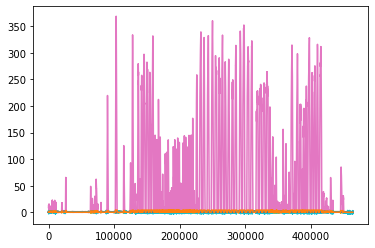

In [20]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, i])

## Plot Dataset Summary

In [24]:
# Count class representation

beh_names = dataset_metadata['label_names']
train_label_count = {name : 0 for name in beh_names}
val_label_count = {name : 0 for name in beh_names}
dev_label_count = {name : 0 for name in beh_names}
test_label_count = {name : 0 for name in beh_names}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        if clip_id in dataset_metadata['train_clip_ids']:
            train_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['val_clip_ids']:
            val_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['test_clip_ids']:
            test_label_count[name] += counts[key]

train_label_perc = {name : 0 for name in beh_names[1:]}
val_label_perc = {name : 0 for name in beh_names[1:]}
dev_label_perc = {name : 0 for name in beh_names[1:]}
test_label_perc = {name : 0 for name in beh_names[1:]}

for name in beh_names[1:]:
    train_label_perc[name] = float(train_label_count[name] / sum([train_label_count[j] for j in beh_names[1:]]))
    val_label_perc[name] = float(val_label_count[name] / sum([val_label_count[j] for j in beh_names[1:]]))
    dev_label_perc[name] = float(dev_label_count[name] / sum([dev_label_count[j] for j in beh_names[1:]]))
    test_label_perc[name] = float(test_label_count[name] / sum([test_label_count[j] for j in beh_names[1:]]))

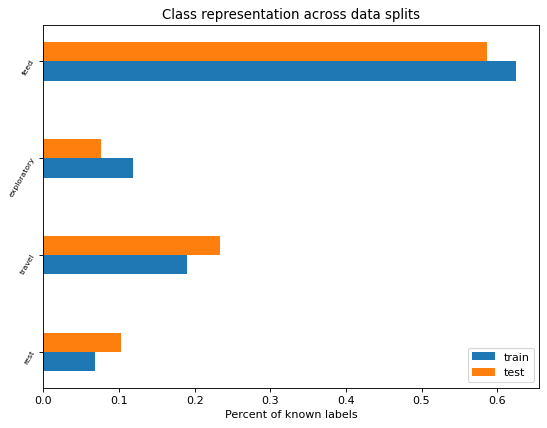

In [25]:
# Plot class representation

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.2
plt.figure(figsize=(8, 6), dpi=80)

plt.barh(keys - offset, [dev_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'train') #We call dev set 'train' in the paper
#plt.barh(keys, [val_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'val')
plt.barh(keys + offset, [test_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'test')
plt.title("Class representation across data splits")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
class_rep_dict = {'train_label_perc' : train_label_perc,
                  'val_label_perc' : val_label_perc,
                  'dev_label_perc' : dev_label_perc,
                  'test_label_perc' : test_label_perc}
with open(numerical_target_fp, 'w') as file:
    yaml.dump(class_rep_dict, file)

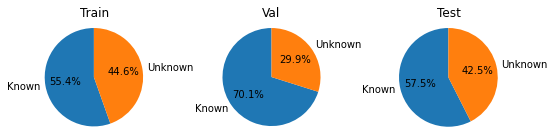

In [23]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,3, figsize = (9,2))
plt.title("blah")

ax[0].pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Train')

ax[1].pie(val_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Val')

ax[2].pie(test_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test')

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()
